# 支持向量機（SVM）



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
%matplotlib inline

### 支持向量基本原理


<img src="3.png" width="900">

如何解決這個線性不可分問題呢？咱們給它映射到高維來試試

$z=x^2+y^2$. 


## 例子

(50, 2)
(50,)


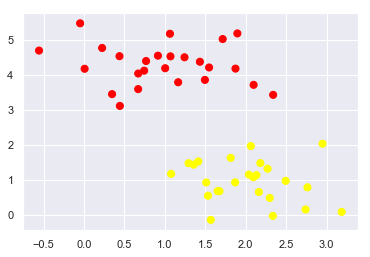

In [2]:
#隨機來點數據
from sklearn.datasets.samples_generator import make_blobs  #制造數據集
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)        #cluster_std 離散程度

print(X.shape)
print(y.shape)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')    #https://matplotlib.org/tutorials/colors/colormaps.html  s 大小

隨便的畫幾條分割線，哪個好來這？

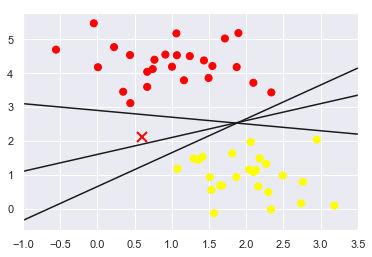

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

## Support Vector Machines: 最小化 *雷區*


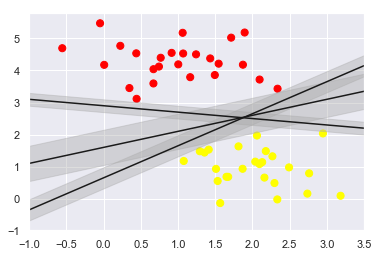

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

### 訓練一個基本的SVM


In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear')
model.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
#繪圖函數
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca() #創建一個實例
    xlim = ax.get_xlim() #獲取x軸範圍
    ylim = ax.get_ylim() #獲取y軸範圍
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30) 
    y = np.linspace(ylim[0], ylim[1], 30)
    

    Y, X = np.meshgrid(y, x)     #從坐標向量返回坐標矩陣
    xy = np.vstack([X.ravel(), Y.ravel()]).T    #連續的扁平數組    #垂直堆疊數組（行方式）  2列
    P = model.decision_function(xy).reshape(X.shape)  #xy到分離超平面的距離
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k', 
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])   #等高線繪圖和標註的類。
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

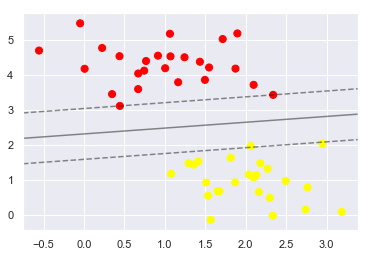

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

* 這條線就是我們希望得到的決策邊界啦

* 觀察發現有3個點做了特殊的標記，它們恰好都是邊界上的點

* 它們就是我們的*support vectors*（支持向量）

* 在Scikit-Learn中, 它們存儲在這個位置 ``support_vectors_``（一個屬性）

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

* 觀察可以發現，只需要支持向量我們就可以把模型構建出來

* 接下來我們嘗試一下，用不同多的數據點，看看效果會不會發生變化

* 分別使用60個和120個數據點

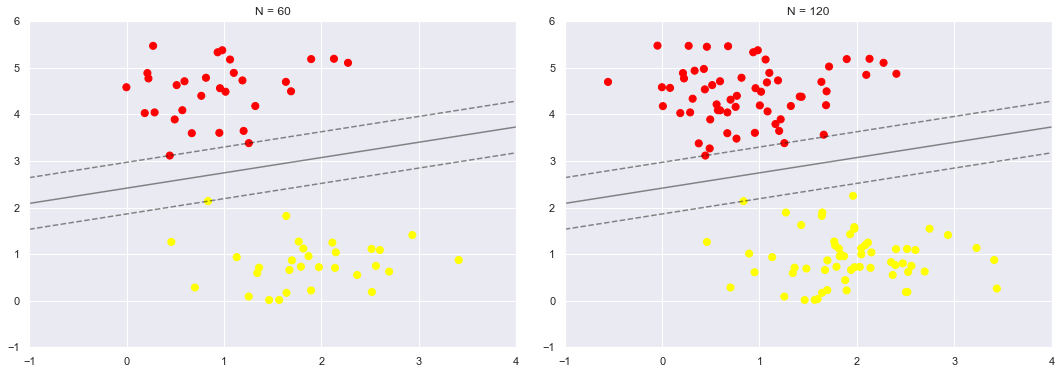

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

* 左邊是60個點的結果，右邊的是120個點的結果
* 觀察發現，只要支持向量沒變，其他的數據怎麽加無所謂！

### 引入核函數的SVM
* 首先我們先用線性的核來看一下在下面這樣比較難的數據集上還能分了嗎？


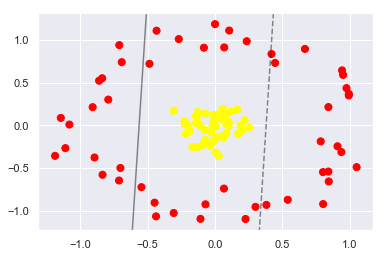

In [10]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

* 壞菜嘍，分不了了，那咋辦呢？試試高維核變換吧！

* We can visualize this extra data dimension using a three-dimensional plot:

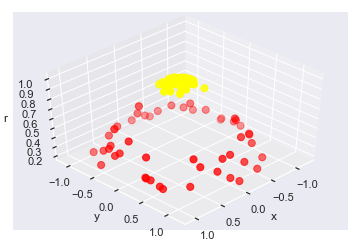

In [11]:
#加入了新的維度r
from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))
def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D(elev=45, azim=45, X=X, y=y)

In [12]:
#加入基函數
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

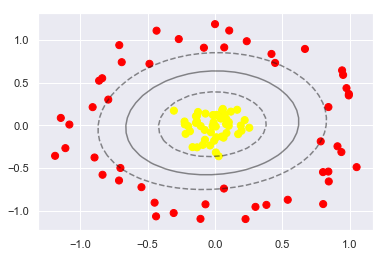

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

使用這種核支持向量機，我們學習一個合適的非線性決策邊界。這種核變換策略在機器學習中經常被使用！

### 調節SVM參數: Soft Margin問題

### 調節C參數
* 當C趨近於無窮大時：意味著分類嚴格不能有錯誤
* 當C趨近於很小的時：意味著可以有更大的錯誤容忍


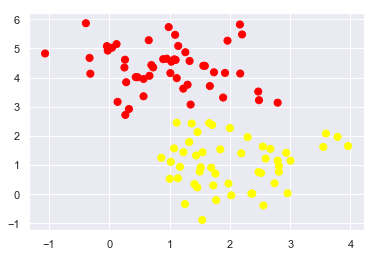

In [14]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

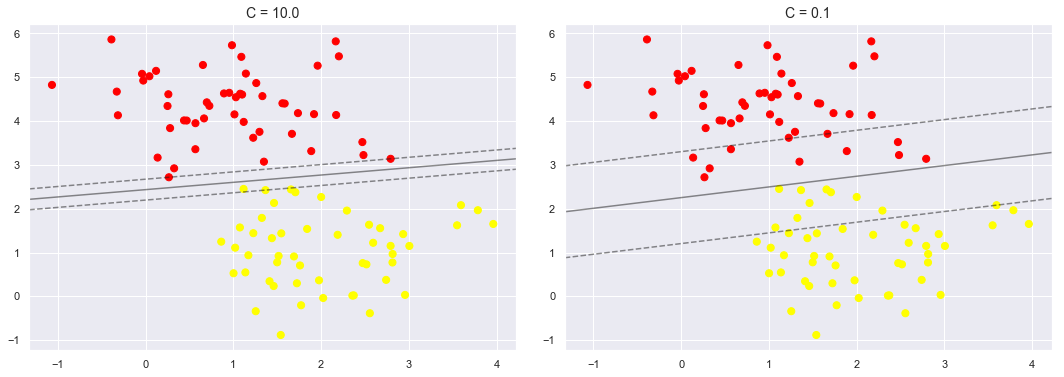

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14) 

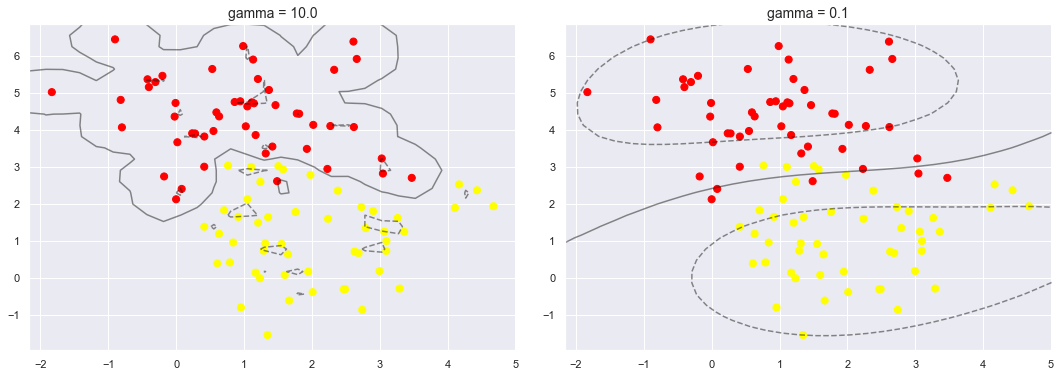

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, gamma in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='rbf', gamma=gamma).fit(X, y)        #gamma越大越複雜，gamma越小越簡單
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('gamma = {0:.1f}'.format(gamma), size=14)

## Example: Face Recognition

## 面部識別

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

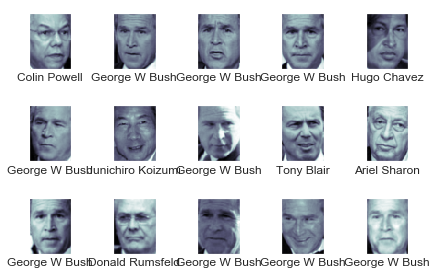

In [18]:
fig, ax = plt.subplots(3, 5)

fig.tight_layout()

for i, axi in enumerate(ax.flat):
    
    axi.imshow(faces.images[i],cmap='bone' )   #黑白 
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

* 每個圖的大小是 [62×47] 
* 在這里我們就把每一個像素點當成了一個特征，但是這樣特征太多了，用PCA降維一下吧！

In [19]:
from sklearn.svm import SVC
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [20]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=40)

使用grid search cross-validation來選擇我們的參數

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0001, 0.0005, 0.001]}

pipe = Pipeline([

            ('pca',PCA(n_components = 150 ,whiten=True, random_state=64)),
            ('svc', SVC(kernel='rbf', class_weight='balanced'))
        ])

grid = GridSearchCV(pipe, param_grid)
grid.fit(Xtrain,ytrain)
print(grid.best_params_)

{'svc__C': 5, 'svc__gamma': 0.001}


In [22]:
model = grid.best_estimator_
yfit = model.predict(Xtest)
yfit.shape

(337,)

看看咋樣吧！

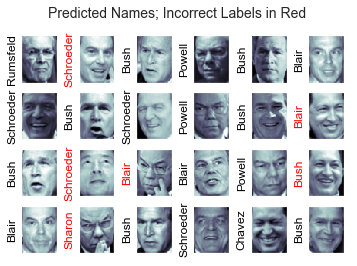

In [23]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [24]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.47      0.50      0.48        16
     Colin Powell       0.72      0.81      0.77        54
  Donald Rumsfeld       0.79      0.79      0.79        34
    George W Bush       0.91      0.88      0.90       136
Gerhard Schroeder       0.74      0.85      0.79        27
      Hugo Chavez       0.81      0.72      0.76        18
Junichiro Koizumi       1.00      0.87      0.93        15
       Tony Blair       0.82      0.73      0.77        37

      avg / total       0.82      0.82      0.82       337



* 精度(precision) = 正確預測的個數(TP)/被預測正確的個數(TP+FP)
* 召回率(recall)=正確預測的個數(TP)/預測個數(TP+FN)
* F1 = 2*精度*召回率/(精度+召回率)

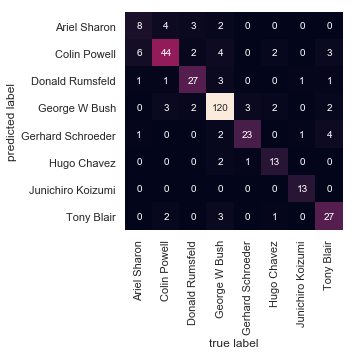

In [25]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

* 這樣顯示出來能幫助我們查看哪些人更容易弄混